## Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import h5py

## Data Preprocessing

In [2]:
os.environ['KAGGLE_USERNAME'] = "prasadnaik24" # username from the json file
os.environ['KAGGLE_KEY'] = "cfc22cee6523029bdccd29b9929fbc8c" # key from the json file

!kaggle datasets  download --force -d kumaresanmanickavelu/lyft-udacity-challenge

100% 5.11G/5.11G [02:28<00:00, 40.9MB/s]
100% 5.11G/5.11G [02:28<00:00, 37.0MB/s]


In [3]:
!unzip lyft-udacity-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: datac/dataC/CameraSeg/02_00_004.png  
  inflating: datac/dataC/CameraSeg/02_00_005.png  
  inflating: datac/dataC/CameraSeg/02_00_014.png  
  inflating: datac/dataC/CameraSeg/02_00_015.png  
  inflating: datac/dataC/CameraSeg/02_00_024.png  
  inflating: datac/dataC/CameraSeg/02_00_025.png  
  inflating: datac/dataC/CameraSeg/02_00_034.png  
  inflating: datac/dataC/CameraSeg/02_00_035.png  
  inflating: datac/dataC/CameraSeg/02_00_044.png  
  inflating: datac/dataC/CameraSeg/02_00_045.png  
  inflating: datac/dataC/CameraSeg/02_00_054.png  
  inflating: datac/dataC/CameraSeg/02_00_055.png  
  inflating: datac/dataC/CameraSeg/02_00_064.png  
  inflating: datac/dataC/CameraSeg/02_00_065.png  
  inflating: datac/dataC/CameraSeg/02_00_074.png  
  inflating: datac/dataC/CameraSeg/02_00_075.png  
  inflating: datac/dataC/CameraSeg/02_00_084.png  
  inflating: datac/dataC/CameraSeg/02_00_085.png  
  inflating: datac/dataC/Camera

In [4]:
def extract_dataFiles(folders, path):
    """
    parameters
    ----------
    folders: data folders. each data folders contains input images and masks
    path: path to input images/segmentation masks

    function
    --------
    accesses every folder in the dataset and extracts each filename
    and appends it to a list and returns the list.
    

    returns
    -------
    list of image files
    """

    imagefiles = []
    for folder in folders:
        #files = glob.glob('../input/lyft-udacity-challenge/'+folder+'/'+folder+'/'+path+'/*.png') (when using Kaggle)
        #files = glob.glob('rawData/'+folder+'/'+folder+'/'+path+'/*.png') (when running locally)
        files = glob.glob(folder+'/'+folder+'/'+path+'/*.png')
        for file in files:
            imagefiles.append(file)

    return imagefiles

def image_processing(imageFile, maskFile):
    """
    parameters
    ----------
    imageFile: TensorSliceDataset
    maskFile: TensorSliceDataset

    function
    --------
    processes each input image and segmentation mask in the dataset
    by reading and decoding the png files and resizing them.

    returns
    -------
    processed input images and segmentation masks
    """
    inputImage = tf.io.read_file(imageFile)
    inputImage = tf.image.decode_png(inputImage, channels = 3)
    inputImage = tf.image.convert_image_dtype(inputImage, tf.float32)
    inputImage = tf.image.resize(inputImage, (256, 256), method = 'nearest')

    segMask = tf.io.read_file(maskFile)
    segMask = tf.image.decode_png(segMask, channels = 3)
    segMask = tf.math.reduce_max(segMask, axis = -1, keepdims = True)
    segMask = tf.image.resize(segMask, (256, 256), method = 'nearest')

    return inputImage, segMask

def prepare_data(imagesFilePath, masksFilePath, batchSize, bufferSize):
    """
    parameters
    ----------
    imagesFilePath: list of input image filenames
    masksFilePath: list of segmentation mask filenames

    function
    --------
    prepares a tensorflow dataset. maps each input image and segmentation mask
    to the the image_processing(imageFile, maskFile) function

    returns
    -------
    tensorflow dataset
    """
    inputs = tf.constant(imagesFilePath)
    masks = tf.constant(masksFilePath)

    dataset = tf.data.Dataset.from_tensor_slices((inputs, masks))
    dataset = dataset.map(image_processing)
    dataset = dataset.cache().shuffle(bufferSize).batch(batchSize)

    return dataset

## U-Net Model

In [5]:
def encoder_block(entered_input, output_filters):
    """
    parameters
    ----------
    entered_input: output of the previous layer
    output_filters: number of output filters

    function
    --------
    implements the encoder part of the U-Net architecture: two convolution
    layers each followed by an activation layer and a max pooling layer

    returns
    -------
    encoded input
    """
    convolution1 = layers.Conv2D(filters = output_filters,
                               kernel_size = 3,
                               padding = 'same')(entered_input)
    batchnorm1 = layers.BatchNormalization()(convolution1)
    activation1 = Activation("relu")(batchnorm1)

    convolution2 = layers.Conv2D(filters = output_filters,
                               kernel_size = 3,
                               padding = 'same')(activation1)
    batchnorm2 = layers.BatchNormalization()(convolution2)
    activation2 = Activation("relu")(batchnorm2)

    skip_connection = activation2

    max_pooling = layers.MaxPooling2D(pool_size = (2,2))(activation2)

    return skip_connection, max_pooling

def bottleneck_layer(entered_input, output_filters):
    """
    parameters
    ----------
    entered_input: output of the previous layer
    output_filters: number of output filters

    function
    --------
    implements the bottle neck part of the U-Net architecture: two convolution
    layers, each followed by an activation layer

    returns
    -------
    bottleneck output
    """

    convolution1 = layers.Conv2D(filters = output_filters,
                               kernel_size = 3,
                               padding = 'same', kernel_initializer="he_normal")(entered_input)
    batchnorm1 = layers.BatchNormalization()(convolution1)
    activation1 = layers.ReLU()(batchnorm1)

    convolution2 = layers.Conv2D(filters = output_filters,
                               kernel_size = 3,
                               padding = 'same', kernel_initializer="he_normal")(activation1)
    batchnorm2 = layers.BatchNormalization()(convolution2)
    activation2 = layers.ReLU()(batchnorm2)

    return activation2

def decoder_block(entered_input, skip_connection_input, output_filters):
    """
    parameters
    ----------
    entered_input: output of the previous layer
    skip_connection_input: input from the skip connection after cropping
    output_filters: number of output filters

    function
    --------
    implements the decoding part of the U-Net architecture: upsampling followed
    by concatenation of skip connection and upsampling output, two convolution
    layers, each followed by an activation layer

    returns
    -------
    decoded output
    """
    upsampling = layers.Conv2DTranspose(output_filters,
                                        kernel_size = 3, strides = (2,2),
                                        padding = 'same', kernel_initializer="he_normal")(entered_input)
    concatenated = concatenate([upsampling, skip_connection_input], axis = 3)

    convolution1 = layers.Conv2D(filters = output_filters,
                                 kernel_size = 3,
                                 padding = 'same', kernel_initializer="he_normal")(concatenated)
    batchnorm1 = layers.BatchNormalization()(convolution1)
    activation1 = Activation("relu")(batchnorm1)

    convolution2 = layers.Conv2D(filters = output_filters,
                                 kernel_size = 3,
                                 padding = 'same', kernel_initializer="he_normal")(activation1)
    batchnorm2 = layers.BatchNormalization()(convolution2)
    activation2 = Activation("relu")(batchnorm2)

    return activation2

def unet(input_shape, num_classes):
    """
    parameters
    ----------
    input_shape: shape of input image
    num_classes: number of classes in the output segmentation mask

    function
    --------
    combines encoder_block(), bottleneck_layer(), and decoder_block() to implement
    the U-Net architecture

    returns
    -------
    u-net model
    """

    # INPUT LAYER
    input_layer = layers.Input(shape = input_shape)

    # FIRST ENCODER BLOCK (enconv1_2 used for skip connection)
    enconv1_2, max_pooled1 = encoder_block(input_layer, output_filters = 64)

    # SECOND ENCODER BLOCK (enconv2_2 used for skip connection)
    enconv2_2, max_pooled2 = encoder_block(max_pooled1, output_filters = 128)

    # THIRD ENCODER BLOCK (enconv3_2 used for skip connection)
    enconv3_2, max_pooled3 = encoder_block(max_pooled2, output_filters = 256)

    # FOURTH ENCODER BLOCK (enconv4_2 used for skip connection)
    enconv4_2, max_pooled4 = encoder_block(max_pooled3, output_filters = 512)

    # BOTTLENECK LAYER
    bottleneck = bottleneck_layer(max_pooled4, output_filters = 1024)

    # FIRST DECODER BLOCK
    deconv1 = decoder_block(entered_input = bottleneck, skip_connection_input = enconv4_2, output_filters = 512)

    # SECOND DECODER BLOCK
    deconv2 = decoder_block(entered_input = deconv1, skip_connection_input = enconv3_2, output_filters = 256)

    # THIRD DECODER BLOCK
    deconv3 = decoder_block(entered_input = deconv2, skip_connection_input = enconv2_2, output_filters = 128)

    # FOURTH DECODER BLOCK
    deconv4 = decoder_block(entered_input = deconv3, skip_connection_input = enconv1_2, output_filters = 64)

    # OUTPUT SEGMENTATION MAP
    output = layers.Conv2D(num_classes, 1, padding = 'same', activation = 'sigmoid')(deconv4)

    model = Model(inputs=input_layer, outputs=output)

    return model

## Predictions

In [6]:
def predict_mask(model, test_dataset):
    """
    parameters
    ----------
    model: u-net model
    test_dataset: dataset to perform predictions on 

    function
    --------
    predicts the output segmentation mask using the trained unet model and
    plots the predictions along with the input image and true segmentation mask

    returns
    -------
    none
    """
    test_dataset.shuffle(500)
    for image, mask in test_dataset:
        predicted_mask = model.predict(image)
        predicted_mask = tf.argmax(predicted_mask, axis = -1)

        plt.subplot(131); plt.imshow(image[0]); plt.title("Image")
        plt.subplot(132); plt.imshow(mask[0]); plt.title("True Mask")
        plt.subplot(133); plt.imshow(predicted_mask[0]); plt.title("Predicted Mask")
        plt.show()

## MAIN FUNCTION

Epoch 1/15
125/125 [==============================] - 83s 573ms/step - loss: 0.5773 - accuracy: 0.8336 - val_loss: 2.9188 - val_accuracy: 0.4139 - lr: 0.0010
Epoch 2/15
125/125 [==============================] - 69s 553ms/step - loss: 0.2216 - accuracy: 0.9337 - val_loss: 3.2799 - val_accuracy: 0.3536 - lr: 0.0010
Epoch 3/15
125/125 [==============================] - 69s 554ms/step - loss: 0.1634 - accuracy: 0.9496 - val_loss: 1.8391 - val_accuracy: 0.6213 - lr: 0.0010
Epoch 4/15
125/125 [==============================] - 69s 555ms/step - loss: 0.1353 - accuracy: 0.9576 - val_loss: 0.9258 - val_accuracy: 0.7655 - lr: 0.0010
Epoch 5/15
125/125 [==============================] - 69s 555ms/step - loss: 0.1263 - accuracy: 0.9599 - val_loss: 0.3787 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 6/15
125/125 [==============================] - 69s 555ms/step - loss: 0.0986 - accuracy: 0.9680 - val_loss: 0.2112 - val_accuracy: 0.9318 - lr: 0.0010
Epoch 7/15
125/125 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Plotting Training and Validation Loss


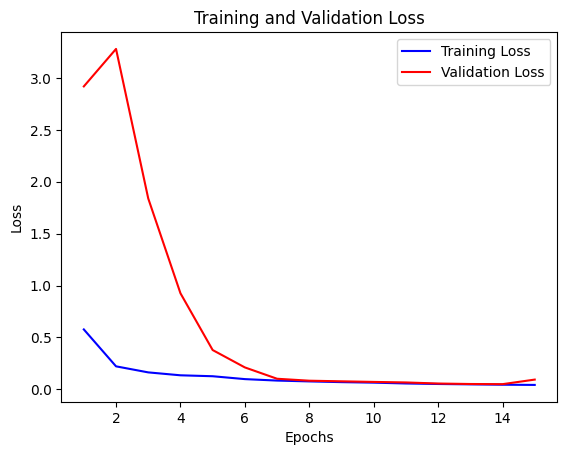


Plotting Training and Validation Accuracy


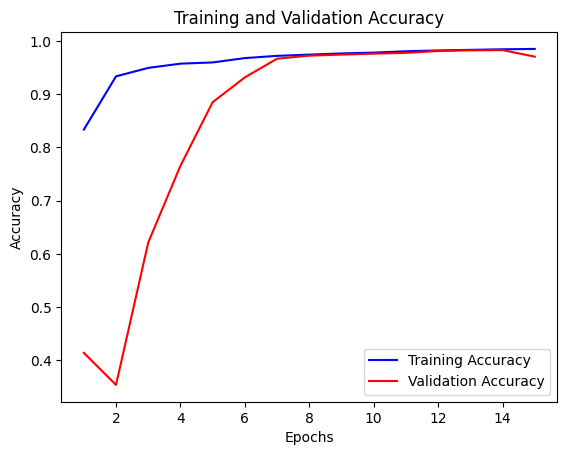

1/1 [==============================] - 1s 569ms/step


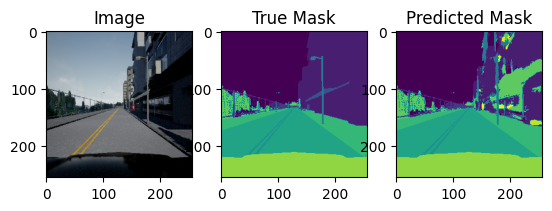

1/1 [==============================] - 0s 39ms/step


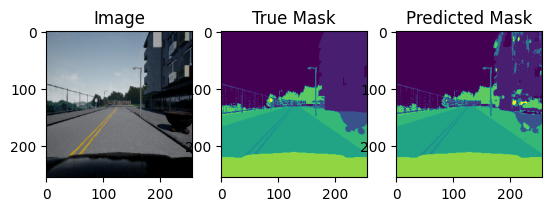

1/1 [==============================] - 0s 40ms/step


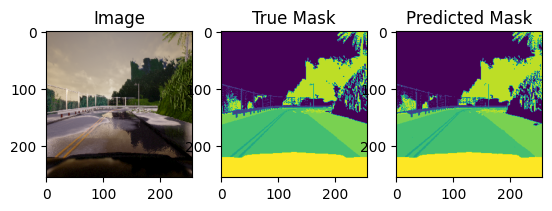

1/1 [==============================] - 0s 39ms/step


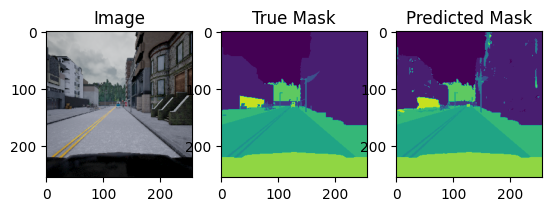

1/1 [==============================] - 0s 40ms/step


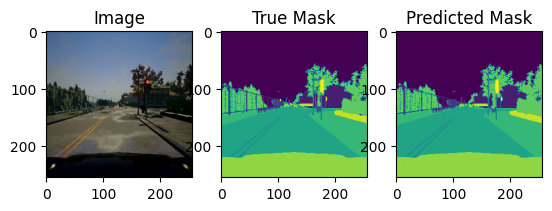

1/1 [==============================] - 0s 33ms/step


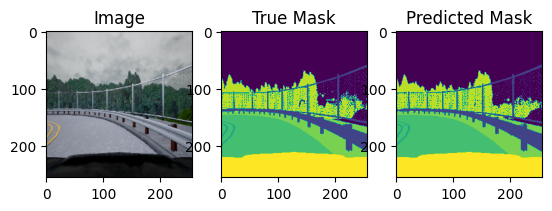

1/1 [==============================] - 2s 2s/step


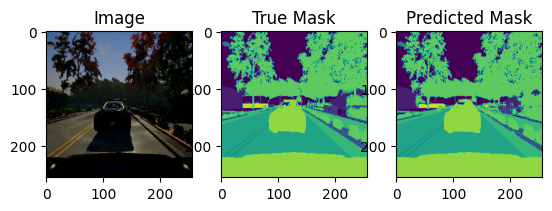

In [8]:
def semanticSegmentation():
    """
    pipeline
    --------
    - extracting data files
    - splitting files into training and test data
    - prepare training and test data
    - define model
    - compile model
    - train model
    - predict segmentation masks of input images of test set

    function
    --------
    main function. combines all the functions previously defined to implement
    semantic segmentation

    returns
    -------
    none
    """
    # extracting data files
    dataFolders = ['dataA', 'dataB', 'dataC', 'dataD', 'dataE']
    inputImageFiles = extract_dataFiles(dataFolders, 'CameraRGB')
    segmentationMaskFiles = extract_dataFiles(dataFolders, 'CameraSeg')

    # splitting data into training and test set
    train_inputs, val_inputs, train_masks, val_masks = train_test_split(inputImageFiles, segmentationMaskFiles,
                                                                          train_size = 0.8, random_state = 0)
    validation_inputs, test_inputs, validation_masks, test_masks = train_test_split(val_inputs, val_masks,
                                                                                    train_size = 0.8, random_state = 0)

    # preparing training and test dataset
    train_ds = prepare_data(train_inputs, train_masks, 32, 500)
    validation_ds = prepare_data(validation_inputs, validation_masks, 32, 500)
    test_ds = prepare_data(test_inputs, test_masks, 32, 500)

    # defining unet model
    model = unet((256, 256, 3), 13)
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    tf.keras.utils.plot_model(model, show_shapes = True)

    # defining model callbacks
    earlyStopping_callback = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=1e-1, patience = 3, min_lr = 2e-6)

    # training the model
    unet_semanticSegmentation = model.fit(train_ds, validation_data = validation_ds, batch_size = 16, epochs = 15, callbacks = [earlyStopping_callback, reduce_lr], shuffle = True)
    model.save('unet_semanticSegmentationv3.h5')

    # plotting training and loss curves
    print("\nPlotting Training and Validation Loss")
    loss = unet_semanticSegmentation.history['loss']
    val_loss = unet_semanticSegmentation.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plotting training and validation accuracy
    print("\nPlotting Training and Validation Accuracy")
    loss = unet_semanticSegmentation.history['accuracy']
    val_loss = unet_semanticSegmentation.history['val_accuracy']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # predicting segmentation masks on some of the test data
    predict_mask(model, test_ds)

semanticSegmentation()